In [1]:
# Mengimpor library
import re
import locale

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from joblib import Parallel
from joblib import delayed

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Data Ingestion

In [2]:
# Menyiapkan format bahasa dan mengunduh dictionary
locale.setlocale(locale.LC_ALL, '')
nltk.download(['stopwords', 'punkt'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fahmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fahmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Kumpulan stopwords
stopwords_list = set(stopwords.words('english') + ['AT_USER','URL'])
stemmer = SnowballStemmer(language='english')

In [4]:
# membaca data dari file CSV
names = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv(r'../datasets/twitter-sentiments.csv', names=names)

## Exploratory Data Analysis

In [5]:
# menampilkan informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
# Menampilkan sampel data
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<AxesSubplot:>

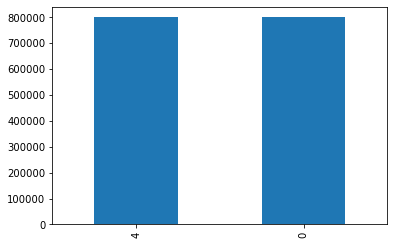

In [7]:
# Menghitung banyaknya data untuk setiap kelas
df["target"].value_counts().plot(kind="bar")

## Preprocessing

In [8]:
# Memisahkan feature dan label
texts = df["text"].values
targets = df["target"].values

In [9]:
# Fungsi untuk mengubah id 4 menjadi 1 dan sisanya 0
def preprocess_target(target):
    return np.where(target == 4, 1, 0)

targets = [preprocess_target(target) for target in targets]

In [10]:
# Fungsi untuk melakukan pembersihan teks
def preprocess_text(text):
    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'AT_USER', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    text = word_tokenize(text)
    text = [word for word in text if word not in stopwords_list and word.isalpha()]
    text = [stemmer.stem(word) for word in text]
    return ' '.join(text)

texts = Parallel(n_jobs=4, verbose=10)(delayed(preprocess_text)(text) for text in texts)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1994s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0040s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0080s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0120s.) Setting batch_size=16.
[Parallel(n_jobs=4)]: Done 156 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0080s.) Setting batch_size=32.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0200s.) Setting batch_size=64.
[Pa

In [11]:
# Membuat korpus kata-kata umum
freqdist = FreqDist()
for sentence in texts:
    for word in word_tokenize(sentence):
        freqdist[word] += 1

freqdist.most_common(10)

[('go', 138145),
 ('get', 110482),
 ('day', 103290),
 ('good', 91979),
 ('work', 87172),
 ('like', 83516),
 ('love', 82126),
 ('quot', 73159),
 ('got', 70858),
 ('today', 68241)]

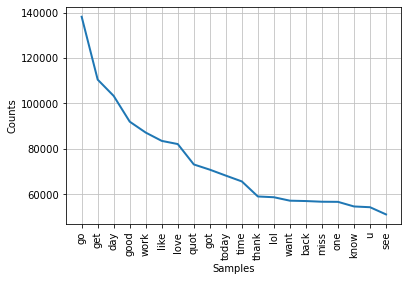

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [12]:
# Visualisasi kata-kata umum
freqdist.plot(20, cumulative=False)

In [13]:
# Membagi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(texts, targets, test_size=0.33, random_state=42, stratify=targets)

## Training

In [14]:
# Membuat model
pipelines = [('vect', CountVectorizer()),
             ('tfidf', TfidfTransformer()),
             ('clf', MultinomialNB())]
classifier = Pipeline(pipelines, verbose=True)
classifier.fit(X_train, y_train)

[Pipeline] .............. (step 1 of 3) Processing vect, total=   9.7s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.7s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.7s


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())],
         verbose=True)

## Evaluation

In [15]:
# Melakukan prediksi menggunakan data uji
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.75      0.77      0.76    264000
           1       0.76      0.75      0.75    264000

    accuracy                           0.76    528000
   macro avg       0.76      0.76      0.76    528000
weighted avg       0.76      0.76      0.76    528000



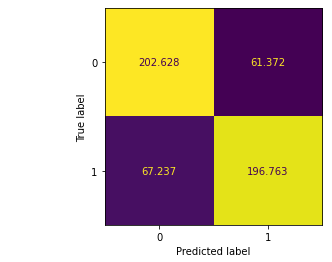

In [16]:
# Membuat confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(values_format='n')

## Prediction

In [17]:
# Lakukan pediksi satu kalimat
pred_text = ["this tweet is really good", "this tweet is really horrible"]
pred_input = [preprocess_text(x) for x in pred_text]

In [18]:
# Prediksi kelas
classifier.predict(pred_input)

array([1, 0])